In [1]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import col,sum
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
from pyspark.sql.types import DateType

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [3]:
spark

In [43]:
def load_data(filename):
    
    '''
    Funtion to load data and remove null, empty strings.
    INPUT
    filename = name of file as well the path
    OUTPUT
    df - a spark dataframe with no null rows for primary key
    '''
    
    df = spark.read.json(filename)
    
    print('\n Data Set loaded Succesfully')
    print("\n Count of rows in dataframe: {}".format(df.count()))
    
    return df
    

In [44]:
path = "mini_sparkify_event_data.json"
df = load_data(path)


 Data Set loaded Succesfully

 Count of rows in dataframe: 286500


In [45]:
print(df.printSchema())

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

None


In [46]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [36]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

In [47]:
df.count()

286500

## Removing the Missing values

In [48]:
def remove_na(df):
    
    print("Removing the NA Values in the dataset ")
    print("-"*115)
    print("\n The size of the Data set before removing NA:",df.count())
    
    df = df.dropna(how = "any", subset = ["userId", "sessionId"])
    df = df.filter(df["userId"] != "")
    
    print("\n The size of the Data set after removing NA:",df.count())
    
    print("\n Updated Table after removing the NA Values ")
    print("-"*115)
    
    df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show() 
    
    return df

In [49]:
df = remove_na(df)

Removing the NA Values in the dataset 
-------------------------------------------------------------------------------------------------------------------

 The size of the Data set before removing NA: 286500

 The size of the Data set after removing NA: 278154

 Updated Table after removing the NA Values 
-------------------------------------------------------------------------------------------------------------------
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|    

## Some Explorations

In [51]:
def add_date_columns(df):
    '''
    Funtion to add date/time related columns to the dataframe.
    INPUT - a spark dataframe
    OUPUT - a spark dataframe with calculated fields: hour, month, year, day
    '''
    # create a function to get hour, month, year, day from timestamp
    get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
    get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
    get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year)
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
    
    
    # add hour, month, year, day, date columns to the dataframe
    df = df.withColumn("hour", get_hour(df.ts))
    df = df.withColumn("month", get_month(df.ts))
    df = df.withColumn("year", get_year(df.ts))
    df = df.withColumn("day", get_day(df.ts))
    df = df.withColumn("date", from_unixtime(df.ts/1000).cast(DateType()))
    
    #df_test2.withColumn('date_again', func.from_unixtime('timestamp').cast(DateType()))
    
    
    return df

In [52]:
df = add_date_columns(df)

In [53]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2', month='10', year='2018', day='1', date=datetime.date(2018, 10, 1))

In [55]:
print(df.printSchema())

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- day: string (nullable = true)
 |-- date: date (nullable = true)

None


In [64]:
def get_hour_stats(df):
    
    '''
    Funtion to load data and plot the scatter plot for hour by hour stats.
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a scatter plot from matplotlib
    '''
    
    songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))
    songs_in_hour_pd = songs_in_hour.toPandas()
    songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)
    
    
    plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
    plt.xlim(-1, 24);
    plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
    plt.xlabel("Hour")
    plt.ylabel("Songs played");

In [72]:
songs_in_day = df.filter(df.page == "NextSong").groupby(df.day).count().orderBy(df.day.cast("float"))

In [73]:
songs_in_day.show()

+---+-----+
|day|count|
+---+-----+
|  1| 8888|
|  2| 9530|
|  3| 6835|
|  4| 5648|
|  5| 6752|
|  6| 6910|
|  7| 5927|
|  8| 7061|
|  9| 9246|
| 10| 7861|
| 11| 7094|
| 12| 7232|
| 13| 6586|
| 14| 5877|
| 15| 8617|
| 16| 9130|
| 17| 6437|
| 18| 6153|
| 19| 8120|
| 20| 9264|
+---+-----+
only showing top 20 rows



In [55]:
gender_count = df.groupby('gender').count()
gender_count.show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+



In [56]:
gender_count_pd = gender_count.toPandas()
gender_count_pd.set_index('gender',inplace = True)
gender_count_pd

,count
gender,
F,154578
NaN,8346
M,123576


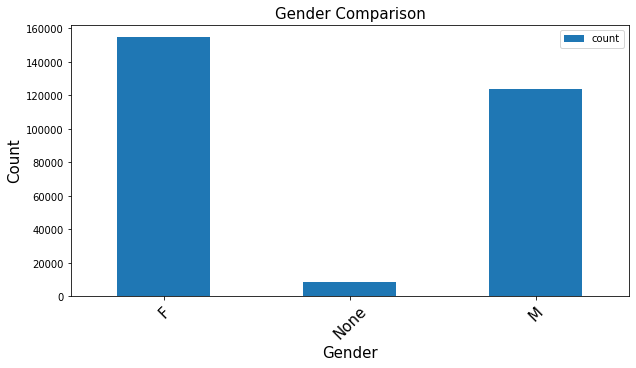

In [57]:
gender_count_pd.plot(kind='bar',figsize=(10,5))

plt.title('Gender Comparison',fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.xlabel('Gender',fontsize = 15)
plt.xticks(fontsize = 15,rotation = 45);

In [58]:
new_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)



In [59]:
new_df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2')]

In [60]:
account_type = df.groupby('level').count()
account_type_pd = account_type.toPandas()
account_type_pd.set_index('level',inplace = True)
account_type_pd

,count
level,
free,58338
paid,228162


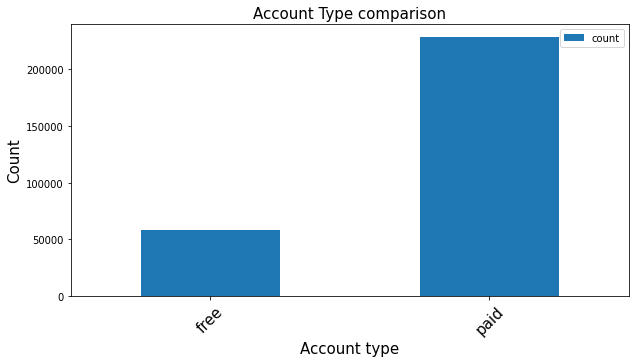

In [61]:
account_type_pd.plot(kind='bar',figsize=(10,5))

plt.title('Account Type comparison',fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.xlabel('Account type',fontsize = 15)
plt.xticks(fontsize = 15,rotation = 45);

In [ ]:
df.select('userId').distinct().count()

### some important exploration

In [62]:
new_df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [63]:
new_df.filter("page = 'Cancellation Confirmation'").count()

52

In [64]:
flag_cancellation = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [65]:
new_df = new_df.withColumn("churn", flag_cancellation("page"))

In [66]:
new_df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2', churn=0)